# Testing GPU-enabled Notebooks for MNIST with Pytorch
In this notebook, we build a simple CNN model for Kaggle (the Pytorch example CNN, in fact) and compare how long it takes to train on GPU compared with CPU.

First of all, when running this notebook on Kaggle you need to go to the Settings pane on the right of the notebook and turn on the GPU option. When you do that, the notebook will restart, moving from a CPU-only to a GPU enabled server.

In [1]:
import numpy as np
import pandas as pd

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


Let's check we do have access to a GPU.

In [2]:
!nvidia-smi

Wed Mar 24 14:54:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:26:00.0  On |                  N/A |
|  0%   39C    P8    36W / 370W |   5811MiB / 24265MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Yes, we have a Tesla K80. Great!

When you run this command, it should tell you the stats for the GPU available, the GPU's temperature, available memory, and which processes are running on the GPU. Hopefully that will be no processes, since we haven't started running any yet.

If you are on a server without GPU compute installed, the nvidia-smi command will not be defined and you will receive the following error:
```
/bin/sh: 1: nvidia-smi: not found
```
To resolve this, change the Settings for your Kaggle kernel so it is "GPU on" instead of "GPU off".

## Importing modules
Import matplotlib, sklearn and pytorch dependencies.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sklearn
import sklearn.model_selection

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

Let's also check to make sure torch thinks we can use the GPU.

In [5]:
torch.cuda.is_available()

True

This should be `True`. If you see `False` here, something is wrong and torch isn't going to be able to run on the GPU.

Possible causes to seeing `False` at this point:
- You don't have a GPU (see above with regards to the `nvidia-smi` check)
- You have a CPU-only version of pytorch installed, in which case you need to install the gpu enabled version
- You don't have the CUDA library
- You don't have the CUDA library path included on either the `PATH` or `LD_LIBRARY_PATH` variables
- You have the wrong version of CUDA for the version of pytorch
- Probably other possiblities

You might encounter some of those problems if you download and run this notebook locally. However, if you're running this on Kaggle's server with the GPU option turned on, everything should run smoothly. When you run it on Kaggle, everything should already be installed correctly.

## Loading data
Pytorch comes with a built-in MNIST data loader. However, we can't use that because we need to use the train/test split offered by Kaggle to correctly work with the framework of this competition. Instead, we will load up the data in the train and test csv files shown above.

In [6]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

In [7]:
train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We need to convert our data from the dataframe into a matrix of inputs (X) and target outputs (y).
Since MNIST is a small dataset, we can load all the data into memory at once to do this in one step. For bigger image datasets, this would not be possible.

In [8]:
X_train_all = train_df.loc[:, train_df.columns != "label"].values.reshape((-1, 28, 28)) / 255
y_train_all = train_df['label'].values
X_test = test_df.loc[:, test_df.columns != "label"].values.reshape((-1, 28, 28)) / 255

print('X_train_all.shape: {}'.format(X_train_all.shape))
print('X_train_all.__class__: {}'.format(X_train_all.__class__))
print('y_train_all.shape: {}'.format(y_train_all.shape))
print('y_train_all.__class__: {}'.format(y_train_all.__class__))
print('X_test.shape: {}'.format(X_test.shape))
print('X_test.__class__: {}'.format(X_test.__class__))

X_train_all.shape: (42000, 28, 28)
X_train_all.__class__: <class 'numpy.ndarray'>
y_train_all.shape: (42000,)
y_train_all.__class__: <class 'numpy.ndarray'>
X_test.shape: (28000, 28, 28)
X_test.__class__: <class 'numpy.ndarray'>


Next, let's make a validation set we can use for local evaluation.

In [9]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X_train_all,
    y_train_all,
    test_size=0.1,
    shuffle=True,
    stratify=y_train_all,
    random_state=79508,
)

print('X_train.shape: {}'.format(X_train.shape))
print('X_val.shape: {}'.format(X_val.shape))
print('y_train.shape: {}'.format(y_train.shape))
print('y_val.shape: {}'.format(y_val.shape))

X_train.shape: (37800, 28, 28)
X_val.shape: (4200, 28, 28)
y_train.shape: (37800,)
y_val.shape: (4200,)


We now have a 90/10 stratified split for train and validation.

## Inspecting the data
Check our images look right.

Here, I dump out the contents of the array encoding the first image in the training set. We want to inspect the raw values to make sure the normalisation was done correctly (we are in the [0, 1] range and not [0, 255] or [0, 1/255]). We also want to make sure we have 0 as the background (black) and 1 as the foreground (white).

These bugs can be missed if you just make a plot of the image, because the plotting function will automatically rescale the image and if you're using a pseudo colormap, you may not be sure which way around the colourmap is.

In [10]:
X_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

We've got 0s at the extremities, and can see values approaching but not exceeding 1.0. Looks good to me!

Now lets check the images look sensible and are paired up with the right labels.

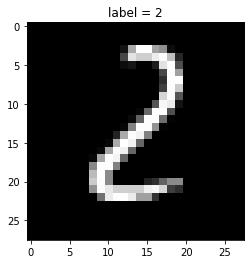

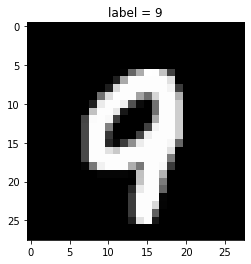

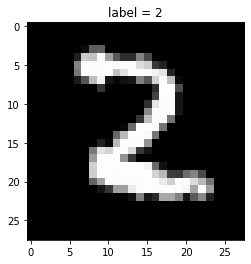

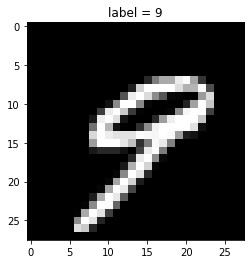

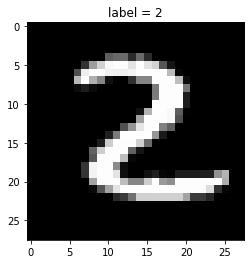

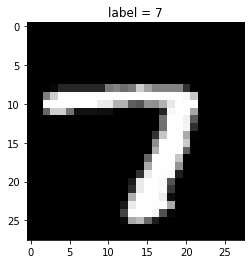

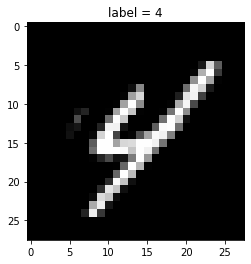

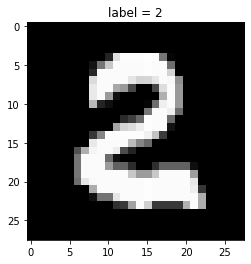

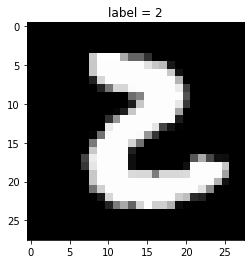

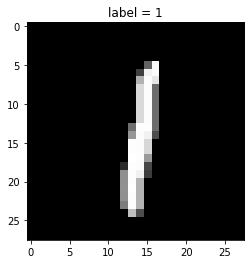

In [11]:
for i in range(10):
    plt.imshow(X_train[i], cmap='gray')
    plt.title('label = {}'.format(y_train[i]))
    plt.show()

That was a surprisingly large amount of '2's. That's a reminder that we should check our label balance!

In [12]:
y_unq = np.unique(y_train_all)
y_unq

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

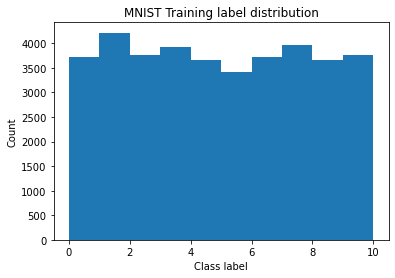

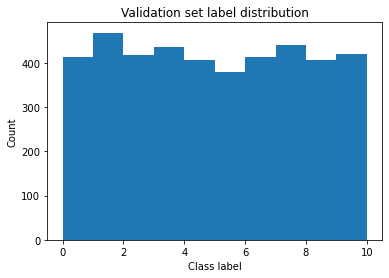

In [17]:
bin_edges = np.concatenate([y_unq, y_unq[[-1]] + 1])
plt.hist(y_train, bins=bin_edges)
plt.xlabel('Class label')
plt.ylabel('Count')
plt.title('MNIST Training label distribution')
plt.savefig('MNIST_training_label_distribution.pdf')
plt.show()
plt.hist(y_val, bins=bin_edges)
plt.xlabel('Class label')
plt.ylabel('Count')
plt.title('Validation set label distribution')
plt.show()

Our figures look correct, and the labels match up with the actual digits.
Also, we can see our stratified split has preserved the data distribution.

The surprisingly large number of "2" digits in our ten sample images (5/10) was just random happenstance.

## Main
Based on Pytorch example found here https://github.com/pytorch/examples/blob/master/mnist/main.py

In [ ]:
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
from collections import defaultdict
import time

In [ ]:
class Net(nn.Module):
    def __init__(self, activation_fn=None, n_targets=10):
        super(Net, self).__init__()
        if activation_fn is None:
            self.activation_fn = F.relu
        else:
            self.activation_fn = activation_fn
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, n_targets)

    def forward(self, x):
        x = self.activation_fn(F.max_pool2d(self.conv1(x), 2))
        x = self.activation_fn(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.activation_fn(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

In [ ]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    train_log = defaultdict(list)
    t_log = time.time()
    n_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        t0 = time.time()
        data, target = data.to(device), target.to(device).long()
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        t1 = time.time()
        loss.backward()
        t2 = time.time()
        optimizer.step()
        t3 = time.time()
        n_samples += data.shape[0]
        if batch_idx % log_interval == 0:
            pred = output.max(1, keepdim=True)[1]
            correct = pred.eq(target.view_as(pred)).sum().item()

            train_log['n_iter'].append(epoch * len(train_loader) + batch_idx + 1)
            train_log['n_samples'].append(n_samples + (epoch - 1) * len(train_loader.dataset))
            train_log['loss'].append(loss.detach())
            train_log['accuracy'].append(100. * correct / data.shape[0])
            train_log['time_batch'].append(t3 - t0)
            train_log['time_batch_forward'].append(t1 - t0)
            train_log['time_batch_backward'].append(t2 - t1)
            train_log['time_batch_update'].append(t3 - t2)
            t4 = time.time()
            train_log['time_batch_avg'].append((t4 - t_log) / log_interval)
            print(
                'Train Epoch: {} [{:5d}/{:5d} ({:3.0f}%)]'
                '\tLoss: {:.6f}'
                '\tTime: {:.4f}ms/batch'.format(
                    epoch, n_samples, len(train_loader.dataset),
                    100. * (batch_idx + 1) / len(train_loader), loss.item(),
                    1000 * (t4 - t_log) / log_interval,
                )
            )
            t_log = time.time()
    return train_log

def test(model, device, test_loader, log_interval):
    model.eval()
    test_loss = 0
    correct = 0
    preds = []
    targets = []
    num_batches = 0
    with torch.no_grad():
        for data, target in test_loader:
            num_batches += 1
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            preds.append(pred.cpu().numpy())
            targets.append(target.cpu().numpy())
    
    # Remove list nesting
    preds = np.concatenate(preds).squeeze()
    targets = np.concatenate(targets).squeeze()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'
        ''.format(
            test_loss,
            correct, len(test_loader.dataset), accuracy,
            )
        )
    return test_loss, accuracy

def main(
        batch_size=64,
        test_batch_size=None,
        n_epoch=10,
        lr=0.01,
        momentum=0.5,
        no_cuda=False,
        seed=1,
        net=Net,
        activation_fn=F.relu,
        n_targets=10,
        log_interval=10,
        ):

    if test_batch_size is None:
        test_batch_size = batch_size

    use_cuda = not no_cuda and torch.cuda.is_available()

    # For reproducible models
    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    # Simple data loader, without augmentations
    # Note that we have a call to expand_dims.
    # This is to insert the channel dimension. Conv2D uses NCHW ordering.
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.Tensor(np.expand_dims(X_train, axis=1)).float(),
            torch.Tensor(y_train).long(),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.Tensor(np.expand_dims(X_val, axis=1)).float(),
            torch.Tensor(y_val).long(),
        ),
        batch_size=batch_size,
        shuffle=True,
    )

    model = net(activation_fn=activation_fn, n_targets=n_targets).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    train_log = defaultdict(list)
    val_log = defaultdict(list)

    for epoch in range(1, n_epoch + 1):
        epoch_log = train(model, device, train_loader, optimizer, epoch, log_interval)
        for key, value in epoch_log.items():
            train_log[key] += value
        
        val_loss, val_accuracy = test(model, device, val_loader, log_interval)
        val_log['loss'].append(val_loss)
        val_log['accuracy'].append(val_accuracy)
    
    return model, train_log, val_log

In [ ]:
def collapse_nested_list(l):
    return [a for b in l for a in b]

def plot_training_log(train_log, val_log):
    #xx_train = np.arange(0, len(train_log['loss']), 1 / len(train_log['loss'][0]))
    xx_train = np.array(train_log['n_samples']) / 1000
    n_epoch = len(val_log['loss'])
    xx_val = np.arange(1, n_epoch + 1) * xx_train[-1] / n_epoch
    
    plt.plot(xx_train, train_log['loss'], 'b')
    # We prepend the first train loss score so there are enough datapoints to plot
    # a line, even with a single epoch.
    plt.plot(np.concatenate([[0], xx_val]), [train_log['loss'][0]] + val_log['loss'], 'ro-')
    plt.title('Loss (lower is better)')
    plt.xlabel('Number of samples presented (1000s)')
    plt.ylabel('Cross-Entropy Loss')
    plt.show()
    
    plt.plot(xx_train, train_log['accuracy'], 'b')
    plt.plot(np.concatenate([[0], xx_val]), [train_log['accuracy'][0]] + val_log['accuracy'], 'ro-')
    plt.title('Accuracy (higher is better)')
    plt.xlabel('Number of samples presented (1000s)')
    plt.ylabel('Accuracy (%)')
    plt.show()
    
    if n_epoch > 1:
        plt.plot(xx_train, train_log['accuracy'], 'b')
        plt.plot(np.concatenate([[0], xx_val]), [10] + val_log['accuracy'], 'ro-')
        plt.ylim([90, 100])
        plt.title('Accuracy, zoomed in')
        plt.xlabel('Number of samples presented (1000s)')
        plt.ylabel('Accuracy (%)')
        plt.show()
    
    plt.plot(xx_train, 1000 * np.array(train_log['time_batch_avg']), 'b')
    plt.title('Training speed (lower is better)')
    plt.xlabel('Number of samples presented (1000s)')
    plt.ylabel('Duration per batch (ms)')
    plt.show()

In [ ]:
# Check we can train a single epoch on GPU
t0 = time.time()
model, train_log, val_log = main(no_cuda=False, n_epoch=1)
t1 = time.time()
print('Training completed in {} seconds.'.format(t1 - t0))
plot_training_log(train_log, val_log)

In [ ]:
# Try on CPU to compare compute time
t0 = time.time()
model, train_log, val_log = main(no_cuda=True, n_epoch=1)
t1 = time.time()
print('Training completed in {} seconds.'.format(t1 - t0))
plot_training_log(train_log, val_log)

We can see that the GPU is, overall, maybe about 4-5x faster than CPU (2.2-4.5 seconds vs 12 seconds). This is less than we would expect from prior knowledge of GPU speed-ups and our training time per batch plots (3ms/batch vs 19ms/batch). Presumably part of the reason it is slower is because there an overhead in setting up the model on the GPU.

Also, it should be noted that Kaggle gives you less CPU power when you are working on a GPU-enabled notebook. If you were working on a CPU-only notebook, it would be around 9 seconds to run a single epoch (only 75% of the CPU time we observed here).

In [ ]:
# Train model for 10 epochs
t0 = time.time()
model, train_log, val_log = main(n_epoch=10)
t1 = time.time()
print('Training completed in {} seconds.'.format(t1 - t0))
plot_training_log(train_log, val_log)

To run 10 epochs took us around 19 seconds. For comparison, running this same code block on the CPU (not shown here) would have taken 118 seconds (6x speed-up). If we were on a CPU-only Kaggle kernel server (also not shown), it would have taken 79 seconds (4x speed-up).

Inspect the structure of our model

In [ ]:
print(model)

In [ ]:
try:
    import torchsummary
    torchsummary.summary(model)
except ImportError:
    print('The torchsummary package is not available.')

Check how many parameters our model has.

In [ ]:
def count_parameters(model, only_trainable=True):
    if only_trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

In [ ]:
print('Total params    : {}'.format(count_parameters(model, False)))
print('Trainable params: {}'.format(count_parameters(model, True)))

## Make predictions

In [ ]:
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.Tensor(np.expand_dims(X_test, axis=1)).float(),
    ),
    batch_size=64,
    shuffle=False,
)

If the model is on the GPU, we have to transfer the data to the GPU to run it through the model. We aren't in `main()` any more, so we try to work out where the model is. Unfortunately there isn't a function we can call to check for sure.

You could alternatively move the model to the CPU with `model.cpu()` and then do the prediction step on the CPU, then we'd definitely know where it is.

In [ ]:
def predict(model, test_loader, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available else "cpu")
    elif isinstance(device, str):
        device = torch.device(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for data, in test_loader:
            data = data.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            preds.append(pred.cpu().numpy())
    # Remove list nesting
    preds = np.concatenate(preds).squeeze()
    return preds

Note that in the function `predict`, we are inferring the device that the model is on by assuming `no_cuda` was set to `False`. If you forced the model to run on the CPU earlier, you'll get an error at this step. You can fix that by `preds = predict(model, test_loader, 'cpu')`.

In [ ]:
preds = predict(model, test_loader)

In [ ]:
preds.shape

In [ ]:
out_df = pd.DataFrame(
    {'ImageId': np.arange(1, preds.shape[0] + 1),
     'Label': preds}
)

Write output to CSV file.

In [ ]:
out_df.to_csv('submission.csv', index=False)

Check file looks okay - columns are correct way around, etc.

In [ ]:
!head submission.csv

We expect to get a performance similar to the validation score of 96.9%, and we actually get 96.2%.

## Next steps
This notebook will get you set up with building MNIST models using Pytorch on the GPU provided by Kaggle. We trained a small model for only 10 epochs (with the actual model training itself taking under 20 seconds). The result isn't a particularly good model! It is very easy to build on this model and improve it, but this notebook should give you a good starting point to do that. Feel free to fork it and adapt it, and try out new things.